In [117]:
# Import Libraries
import os
import sys
import re
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipykernel
import tweepy
import stockmarket
import nltk
import collections
import seaborn as sns
import itertools

In [242]:
# Read in keys from a csv file
readin_authentication = pd.read_csv('../authentication/authentication_tokens.csv', header=0, sep=',')

consumer_key = readin_authentication['consumer_key'][0]
consumer_secret = readin_authentication['consumer_secret'][0]
access_token = readin_authentication['access_token'][0]
access_token_secret = readin_authentication['access_token_secret'][0]

# connect to twitter application 
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
redirect_url = auth.get_authorization_url()
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [243]:
def user_download(userID):
    tweets = api.user_timeline(screen_name=userID, 
                            # 200 is the maximum allowed count
                            count=200,
                            include_rts = False,
                            tweet_mode = 'extended'
                            )
    all_tweets = []
    all_tweets.extend(tweets)
    oldest_id = tweets[-1].id
    while True:
        tweets = api.user_timeline(screen_name=userID, 
                            # 200 is the maximum allowed count
                            count=200,
                            include_rts = False,
                            max_id = oldest_id - 1,
                            # Necessary to keep full_text 
                            # otherwise only the first 140 words are extracted
                            tweet_mode = 'extended'
                            )
        if len(tweets) == 0:
            break
        oldest_id = tweets[-1].id
        all_tweets.extend(tweets)
        # print('N of tweets downloaded till now {}'.format(len(all_tweets)))
        
    # label and clean up tweets
    outtweets = [[tweet.id_str,
                tweet.created_at, 
                tweet.favorite_count, 
                tweet.retweet_count,
                ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet.full_text.encode("utf-8").decode("utf-8")).split()) 
                ] 
                for idx,tweet in enumerate(all_tweets)]
    df_temp = pd.DataFrame(outtweets,columns=["id","created_at","favorite_count","retweet_count", "text"])
    df_temp.to_csv('../data/%s_tweets.csv' % userID,index=False)

In [203]:
user_list = ['jimcramer','KennethLFisher']
for userID in user_list:
    user_download(userID)

In [204]:
csv_files = glob.glob(os.path.join('../data', "*.csv"))
df = pd.DataFrame()
i = 0
for f in csv_files:
    # read the csv file
    df_temp = pd.read_csv(f)
    df_temp['user'] = user_list[i]
    # print the filename
    print(f.split("\\")[-1])
      
    display(df_temp.iloc[0:3])
    print(df_temp.shape)
    # Merging the columns
    df = pd.concat([df_temp,df], names = ['id',	'created_at',	'favorite_count',	'retweet_count',	'text', 'user'])
    i += 1
print()
print(f"size of merged data sets: {df.shape}")


jimcramer_tweets.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1602305304024211457,2022-12-12 14:12:08+00:00,110,12,Lotta stupid deals but deals need to be done I...,jimcramer
1,1602299437258268674,2022-12-12 13:48:49+00:00,39,2,sure was,jimcramer
2,1602084981773406210,2022-12-11 23:36:39+00:00,206,8,Some things transcend games We love Summit New...,jimcramer


(2928, 6)
KennethLFisher_tweets.csv


,id,created_at,favorite_count,retweet_count,text,user
0,1602383327901663232,2022-12-12 19:22:10+00:00,8,1,Always a honor to present at MoneyShow I hope ...,KennethLFisher
1,1602379516747583488,2022-12-12 19:07:02+00:00,3,0,Thanks for the confidence of your comments and...,KennethLFisher
2,1602379340402262016,2022-12-12 19:06:20+00:00,0,0,Thanks for the confidence of your comments and...,KennethLFisher


(3199, 6)

size of merged data sets: (6127, 6)


<class 'pandas.core.series.Series'>


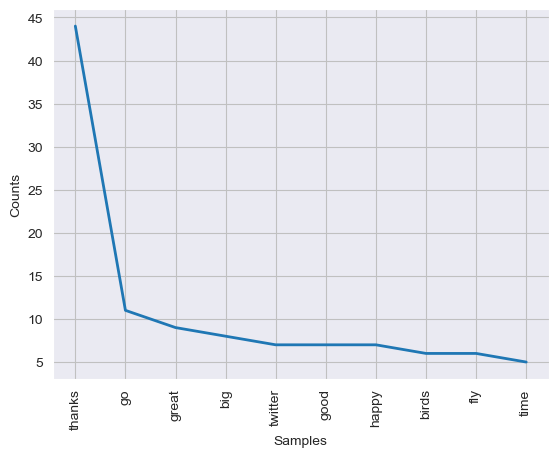

thanks       44
go           11
great         9
big           8
good          7
             ..
lisa          1
birthday      1
winners       1
halloween     1
seconds       1
Name: text, Length: 564, dtype: int64


In [244]:
stop = nltk.corpus.stopwords.words("english") 

# all_words = df['text'].str.lower().str.split(' ').explode()
all_words = df['text'].str.lower().replace(to_replace='(\d)+', value=np.nan,regex=True)

for i in stop :
    all_words = all_words.replace(to_replace=r'\b%s\b'%i, value=np.nan,regex=True)
all_words = all_words.str.lower().str.split(' ').explode().dropna()
print(type(all_words))
counts = all_words.value_counts()
sns.set_style('darkgrid')
nlp_words=nltk.FreqDist(all_words)
nlp_words.plot(10)
print(counts)